# BookCover dataset - transfer learning and fine-tuning approaches with ResNet50
### Training with only 10 classes

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import random
import os
import shutil
from distutils.dir_util import copy_tree

### Create a copy of 10 chosen classes
Based on this paper: http://cs231n.stanford.edu/reports/2017/pdfs/814.pdf include only certain classes

In [3]:
input_data_dir = "/datapool/bookdataset30"
output_data_dir = "/datapool/bookdataset10"

In [4]:
classes_to_include = ["Children's Books", 'Comics & Graphic Novels', 'Computers & Technology', 
                      'Cookbooks, Food & Wine', 'Romance', 'Science & Math', 
                      'Science Fiction & Fantasy', 'Sports & Outdoors','Test Preparation', 'Travel']

In [5]:
if not os.path.exists(output_data_dir):
    os.mkdir(output_data_dir)
    output_train_data_dir = os.path.join(output_data_dir, 'train')
    output_valid_data_dir = os.path.join(output_data_dir, 'valid')
    os.mkdir(output_train_data_dir)
    os.mkdir(output_valid_data_dir)
    dirnames = os.listdir(os.path.join(input_data_dir, 'train'))
    for dirname in dirnames:
        if dirname in classes_to_include:
            print(dirname)   
            os.mkdir(os.path.join(output_train_data_dir, dirname))
            os.mkdir(os.path.join(output_valid_data_dir, dirname))
            copy_tree(os.path.join(input_data_dir, 'train', dirname), os.path.join(output_train_data_dir, dirname))
            copy_tree(os.path.join(input_data_dir, 'valid', dirname), os.path.join(output_valid_data_dir, dirname))
else:
    print("Warning: output dir {} already exists".format(output_data_dir))


Science & Math
Sports & Outdoors
Computers & Technology
Cookbooks, Food & Wine
Children's Books
Test Preparation
Romance
Travel
Comics & Graphic Novels
Science Fiction & Fantasy


In [6]:
!ls -l /datapool/bookdataset10/train/Romance | wc -l

1711


In [7]:
!ls -l /datapool/bookdataset10/valid/Romance | wc -l

191


### Create training/ validation dataset

In [ ]:
from fastai import *
from fastai.vision import *

In [9]:
path = "/datapool/bookdataset10"

In [10]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, bs=75)

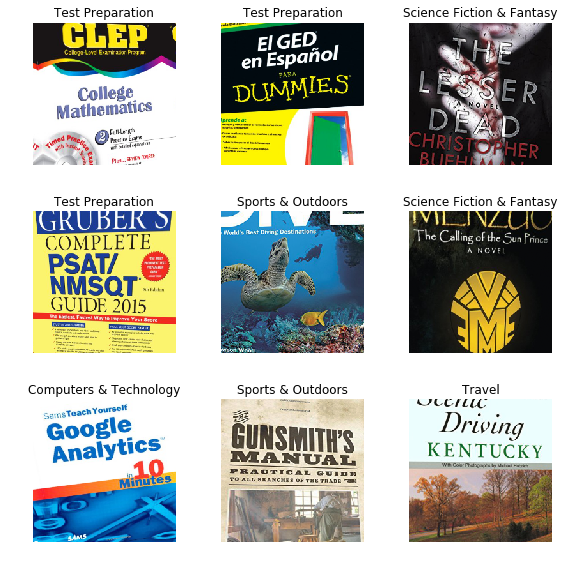

In [11]:
data.show_batch(rows=3, figsize=(8,8))

In [12]:
print(data.classes)
len(data.classes); data.c

["Children's Books", 'Comics & Graphic Novels', 'Computers & Technology', 'Cookbooks, Food & Wine', 'Romance', 'Science & Math', 'Science Fiction & Fantasy', 'Sports & Outdoors', 'Test Preparation', 'Travel']


10

In [13]:
data.train_ds.ds

ImageClassificationDataset of len 17100

In [14]:
data.valid_ds.ds

ImageClassificationDataset of len 1900

### Employing transfer learning, training just the last layer

In [15]:
learn = create_cnn(data, models.resnet50, metrics=[error_rate, accuracy])

Default learning rate is, default_lr = 3e-3

In [16]:
learn.fit_one_cycle(10)

Total time: 20:14
epoch  train_loss  valid_loss  error_rate  accuracy
1      1.603906    1.392880    0.480526    0.519474  (02:03)
2      1.424117    1.301761    0.453684    0.546316  (02:00)
3      1.353752    1.259727    0.428947    0.571053  (02:01)
4      1.310254    1.211355    0.415789    0.584211  (02:01)
5      1.211315    1.201578    0.409474    0.590526  (02:01)
6      1.152717    1.178227    0.410000    0.590000  (02:01)
7      1.083565    1.175068    0.406842    0.593158  (02:01)
8      1.012912    1.165739    0.394737    0.605263  (02:01)
9      0.937828    1.164913    0.396842    0.603158  (02:01)
10     0.945411    1.166730    0.397368    0.602632  (02:01)



In [17]:
learn.save('stage-1')

### Try training all the layers
so unfreeze all of them

In [18]:
learn.unfreeze()

Find a good enough lr

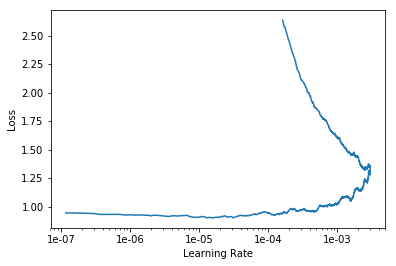

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,3e-3/5))

Total time: 13:34
epoch  train_loss  valid_loss  error_rate  accuracy
1      1.154369    1.324163    0.439474    0.560526  (02:42)
2      1.235094    1.280349    0.448947    0.551053  (02:43)
3      1.073640    1.204068    0.403158    0.596842  (02:43)
4      0.782446    1.178467    0.384210    0.615789  (02:43)
5      0.550700    1.182092    0.376316    0.623684  (02:43)



In [22]:
learn.save('stage-2')

### Interpretation

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

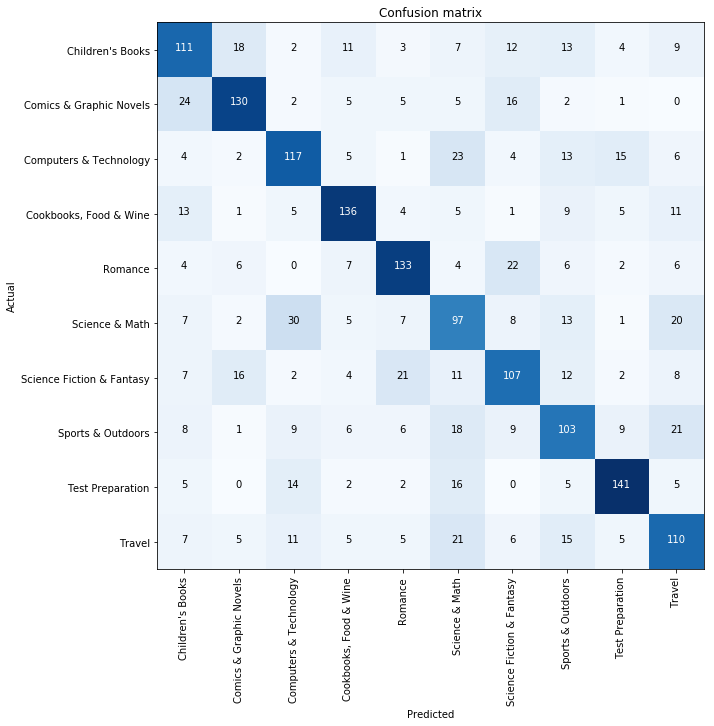

In [28]:
interp.plot_confusion_matrix(figsize=(10,10))